# Mount Google Drive and Setup

In [35]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to the data folders
BASE_PATH = '/content/drive/MyDrive/HMM/'
JEAN_PATH = os.path.join(BASE_PATH, 'Jean-pierre_data')
MARION_PATH = os.path.join(BASE_PATH, 'Marion_data')

print("Data directories:")
print(f"Jean-Pierre: {JEAN_PATH}")
print(f"Marion: {MARION_PATH}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data directories:
Jean-Pierre: /content/drive/MyDrive/HMM/Jean-pierre_data
Marion: /content/drive/MyDrive/HMM/Marion_data


# Load and Explore Data Structure

In [36]:
def explore_data_structure(base_path, participant_name):
    """Explore the nested folder structure"""
    print(f"\n{'='*60}")
    print(f"{participant_name}'s Data Structure")
    print(f"{'='*60}")

    activities = ['jumping', 'standing', 'still', 'walking']

    for activity in activities:
        activity_path = os.path.join(base_path, activity)
        if os.path.exists(activity_path):
            subfolders = sorted([f for f in os.listdir(activity_path)
                               if os.path.isdir(os.path.join(activity_path, f))])
            print(f"\n{activity.upper()}: {len(subfolders)} recordings")
            print(f"  Subfolders: {subfolders[:3]}..." if len(subfolders) > 3 else f"  Subfolders: {subfolders}")

            # Check first subfolder contents
            if subfolders:
                first_folder = os.path.join(activity_path, subfolders[0])
                files = os.listdir(first_folder)
                print(f"  Files in {subfolders[0]}: {files}")

# Explore both participants' data
explore_data_structure(JEAN_PATH, "Jean-Pierre")
explore_data_structure(MARION_PATH, "Marion")


Jean-Pierre's Data Structure

JUMPING: 10 recordings
  Subfolders: ['jumping_1', 'jumping_10', 'jumping_2']...
  Files in jumping_1: ['GyroscopeUncalibrated.csv', 'AccelerometerUncalibrated.csv', 'Annotation.csv', 'Accelerometer.csv', 'Gyroscope.csv', 'TotalAcceleration.csv', 'Metadata.csv']

STANDING: 10 recordings
  Subfolders: ['standing_1', 'standing_10', 'standing_2']...
  Files in standing_1: ['Accelerometer.csv', 'AccelerometerUncalibrated.csv', 'TotalAcceleration.csv', 'GyroscopeUncalibrated.csv', 'Metadata.csv', 'Gyroscope.csv', 'Annotation.csv']

STILL: 10 recordings
  Subfolders: ['still_1', 'still_10', 'still_2']...
  Files in still_1: ['Metadata.csv', 'Annotation.csv', 'TotalAcceleration.csv', 'AccelerometerUncalibrated.csv', 'GyroscopeUncalibrated.csv', 'Accelerometer.csv', 'Gyroscope.csv']

WALKING: 10 recordings
  Subfolders: ['walking_1', 'walking_10', 'walking_2']...
  Files in walking_1: ['AccelerometerUncalibrated.csv', 'GyroscopeUncalibrated.csv', 'Annotation.csv'

# Load and Merge Sensor Data for Each Recording

In [37]:
def load_single_recording(recording_path):
    """
    Load accelerometer and gyroscope data from a single recording folder
    Returns a merged dataframe with both sensors
    """
    try:
        # Load accelerometer data
        acc_path = os.path.join(recording_path, 'Accelerometer.csv')
        gyro_path = os.path.join(recording_path, 'Gyroscope.csv')

        if not os.path.exists(acc_path) or not os.path.exists(gyro_path):
            print(f"  ⚠️ Missing files in {recording_path}")
            return None

        acc_df = pd.read_csv(acc_path)
        gyro_df = pd.read_csv(gyro_path)

        # Check if 'seconds_elapsed' column exists, if not use 'time' or create it
        if 'seconds_elapsed' not in acc_df.columns and 'time' in acc_df.columns:
            acc_df['seconds_elapsed'] = (acc_df['time'] - acc_df['time'].iloc[0]) / 1e9  # Convert nanoseconds to seconds

        if 'seconds_elapsed' not in gyro_df.columns and 'time' in gyro_df.columns:
            gyro_df['seconds_elapsed'] = (gyro_df['time'] - gyro_df['time'].iloc[0]) / 1e9

        # Rename columns to have clear prefixes
        acc_df = acc_df.rename(columns={'x': 'x_acc', 'y': 'y_acc', 'z': 'z_acc'})
        gyro_df = gyro_df.rename(columns={'x': 'x_gyro', 'y': 'y_gyro', 'z': 'z_gyro'})

        # Merge on seconds_elapsed
        merged = pd.merge_asof(
            acc_df.sort_values('seconds_elapsed')[['seconds_elapsed', 'x_acc', 'y_acc', 'z_acc']],
            gyro_df.sort_values('seconds_elapsed')[['seconds_elapsed', 'x_gyro', 'y_gyro', 'z_gyro']],
            on='seconds_elapsed',
            direction='nearest'
        )

        return merged

    except Exception as e:
        print(f"  ❌ Error loading {recording_path}: {str(e)}")
        return None


def load_activity_data(base_path, activity, participant_name):
    """
    Load all recordings for a specific activity and participant
    """
    activity_path = os.path.join(base_path, activity)

    if not os.path.exists(activity_path):
        print(f"⚠️ Activity folder not found: {activity_path}")
        return None

    # Get all subfolders (e.g., jumping_1, jumping_2, etc.)
    subfolders = sorted([f for f in os.listdir(activity_path)
                        if os.path.isdir(os.path.join(activity_path, f))])

    all_recordings = []

    print(f"\n📂 Loading {activity} data for {participant_name}...")

    for subfolder in subfolders:
        recording_path = os.path.join(activity_path, subfolder)
        print(f"  Loading {subfolder}...", end=" ")

        merged_data = load_single_recording(recording_path)

        if merged_data is not None and len(merged_data) > 0:
            # Add metadata
            merged_data['participant'] = participant_name
            merged_data['activity'] = activity
            merged_data['recording_id'] = subfolder
            all_recordings.append(merged_data)
            print(f"✅ {len(merged_data)} samples")
        else:
            print("❌ Failed")

    if all_recordings:
        combined = pd.concat(all_recordings, ignore_index=True)
        print(f"  ✅ Total: {len(combined)} samples from {len(all_recordings)} recordings")
        return combined
    else:
        print(f"  ⚠️ No valid recordings found")
        return None

# Load All Data for Both Participants

In [38]:
activities = ['walking', 'standing', 'jumping', 'still']
all_data = []

print("\n" + "="*60)
print("LOADING ALL DATA")
print("="*60)

# Load Jean-Pierre's data
for activity in activities:
    jp_data = load_activity_data(JEAN_PATH, activity, 'Jean-Pierre')
    if jp_data is not None:
        all_data.append(jp_data)

# Load Marion's data
for activity in activities:
    m_data = load_activity_data(MARION_PATH, activity, 'Marion')
    if m_data is not None:
        all_data.append(m_data)

# Combine all data
if all_data:
    complete_dataset = pd.concat(all_data, ignore_index=True)

    print("\n" + "="*60)
    print("DATA LOADING SUMMARY")
    print("="*60)
    print(f"Total samples: {len(complete_dataset)}")
    print(f"\nSamples per activity:")
    print(complete_dataset.groupby('activity').size())
    print(f"\nSamples per participant:")
    print(complete_dataset.groupby('participant').size())
    print(f"\nRecordings per activity:")
    print(complete_dataset.groupby('activity')['recording_id'].nunique())

    # Save the complete dataset
    complete_dataset.to_csv('Complete_Raw_Dataset.csv', index=False)
    print(f"\n✅ Saved to 'Complete_Raw_Dataset.csv'")
else:
    print("❌ No data loaded!")


LOADING ALL DATA

📂 Loading walking data for Jean-Pierre...
  Loading walking_1... ✅ 974 samples
  Loading walking_10... ✅ 788 samples
  Loading walking_2... ✅ 761 samples
  Loading walking_3... ✅ 793 samples
  Loading walking_4... ✅ 779 samples
  Loading walking_5... ✅ 858 samples
  Loading walking_6... ✅ 839 samples
  Loading walking_7... ✅ 824 samples
  Loading walking_8... ✅ 799 samples
  Loading walking_9... ✅ 855 samples
  ✅ Total: 8270 samples from 10 recordings

📂 Loading standing data for Jean-Pierre...
  Loading standing_1... ✅ 1069 samples
  Loading standing_10... ✅ 1030 samples
  Loading standing_2... ✅ 1093 samples
  Loading standing_3... ✅ 1071 samples
  Loading standing_4... ✅ 985 samples
  Loading standing_5... ✅ 1082 samples
  Loading standing_6... ✅ 1098 samples
  Loading standing_7... ✅ 1052 samples
  Loading standing_8... ✅ 1097 samples
  Loading standing_9... ✅ 1048 samples
  ✅ Total: 10625 samples from 10 recordings

📂 Loading jumping data for Jean-Pierre...
  Lo

# Check Sampling Rates and Data Quality

In [39]:
print("\n" + "="*60)
print("SAMPLING RATE ANALYSIS")
print("="*60)

def calculate_sampling_rate(df):
    """Calculate the sampling rate from time differences"""
    time_diffs = df['seconds_elapsed'].diff().dropna()
    median_interval = time_diffs.median()
    sampling_rate = 1 / median_interval if median_interval > 0 else 0
    return sampling_rate, median_interval

# Check sampling rate for each participant and activity
sampling_info = []

for participant in complete_dataset['participant'].unique():
    for activity in complete_dataset['activity'].unique():
        subset = complete_dataset[
            (complete_dataset['participant'] == participant) &
            (complete_dataset['activity'] == activity)
        ]

        if len(subset) > 1:
            rate, interval = calculate_sampling_rate(subset)
            sampling_info.append({
                'Participant': participant,
                'Activity': activity,
                'Samples': len(subset),
                'Sampling_Rate_Hz': round(rate, 2),
                'Median_Interval_ms': round(interval * 1000, 2)
            })

sampling_df = pd.DataFrame(sampling_info)
print("\n", sampling_df.to_string(index=False))

# Calculate overall statistics
overall_rate = sampling_df['Sampling_Rate_Hz'].mean()
rate_std = sampling_df['Sampling_Rate_Hz'].std()

print(f"\n📊 Overall sampling rate: {overall_rate:.2f} ± {rate_std:.2f} Hz")

# Save sampling rate info
sampling_df.to_csv('Sampling_Rate_Analysis.csv', index=False)
print("\n✅ Saved sampling rate analysis")


SAMPLING RATE ANALYSIS

 Participant Activity  Samples  Sampling_Rate_Hz  Median_Interval_ms
Jean-Pierre  walking     8270             98.70               10.13
Jean-Pierre standing    10625             98.70               10.13
Jean-Pierre  jumping     8360             98.70               10.13
Jean-Pierre    still     8719             98.70               10.13
     Marion  walking     8025            100.54                9.95
     Marion standing     8013            100.54                9.95
     Marion  jumping     8096            100.54                9.95
     Marion    still     6954            100.54                9.95

📊 Overall sampling rate: 99.62 ± 0.98 Hz

✅ Saved sampling rate analysis


# Handle Different Sampling Rates (Resampling)

In [40]:
print("\n" + "="*60)
print("HARMONIZING SAMPLING RATES")
print("="*60)

TARGET_SAMPLING_RATE = 100  # Hz - standard rate for motion analysis

def resample_recording(df, target_rate=100):
    """
    Resample a recording to a target sampling rate using interpolation
    """
    if len(df) < 2:
        return df

    # Get current time range
    start_time = df['seconds_elapsed'].min()
    end_time = df['seconds_elapsed'].max()
    duration = end_time - start_time

    # Create new time points at target rate
    n_samples = int(duration * target_rate)
    new_times = np.linspace(start_time, end_time, n_samples)

    # Interpolate sensor values
    resampled = pd.DataFrame({'seconds_elapsed': new_times})
    for col in ['x_acc', 'y_acc', 'z_acc', 'x_gyro', 'y_gyro', 'z_gyro']:
        if col in df.columns:
            resampled[col] = np.interp(new_times, df['seconds_elapsed'], df[col])

    # Keep metadata (use first row of this recording)
    for col in ['participant', 'activity', 'recording_id']:
        if col in df.columns:
            resampled[col] = df[col].iloc[0]

    return resampled

# Resample all recordings for all participants
print(f"Resampling all data to {TARGET_SAMPLING_RATE} Hz...")

resampled_data = []

# Loop over unique participant + recording_id combinations
for participant, recording_id in complete_dataset[['participant', 'recording_id']].drop_duplicates().values:
    recording = complete_dataset[
        (complete_dataset['participant'] == participant) &
        (complete_dataset['recording_id'] == recording_id)
    ]
    resampled = resample_recording(recording, TARGET_SAMPLING_RATE)
    resampled_data.append(resampled)

harmonized_dataset = pd.concat(resampled_data, ignore_index=True)

print(f"\n✅ Resampling complete!")
print(f"Original samples: {len(complete_dataset)}")
print(f"Harmonized samples: {len(harmonized_dataset)}")
print(f"\nSamples per participant:")
print(harmonized_dataset.groupby('participant').size())
print(f"\nSamples per activity (harmonized):")
print(harmonized_dataset.groupby('activity').size())

# Save harmonized dataset
harmonized_dataset.to_csv('Harmonized_Dataset.csv', index=False)
print(f"\n✅ Saved to 'Harmonized_Dataset.csv'")



HARMONIZING SAMPLING RATES
Resampling all data to 100 Hz...

✅ Resampling complete!
Original samples: 67062
Harmonized samples: 67405

Samples per participant:
participant
Jean-Pierre    36455
Marion         30950
dtype: int64

Samples per activity (harmonized):
activity
jumping     16539
standing    18742
still       15743
walking     16381
dtype: int64

✅ Saved to 'Harmonized_Dataset.csv'


# Visualize Sample Data


GENERATING VISUALIZATIONS
Plotting walking...


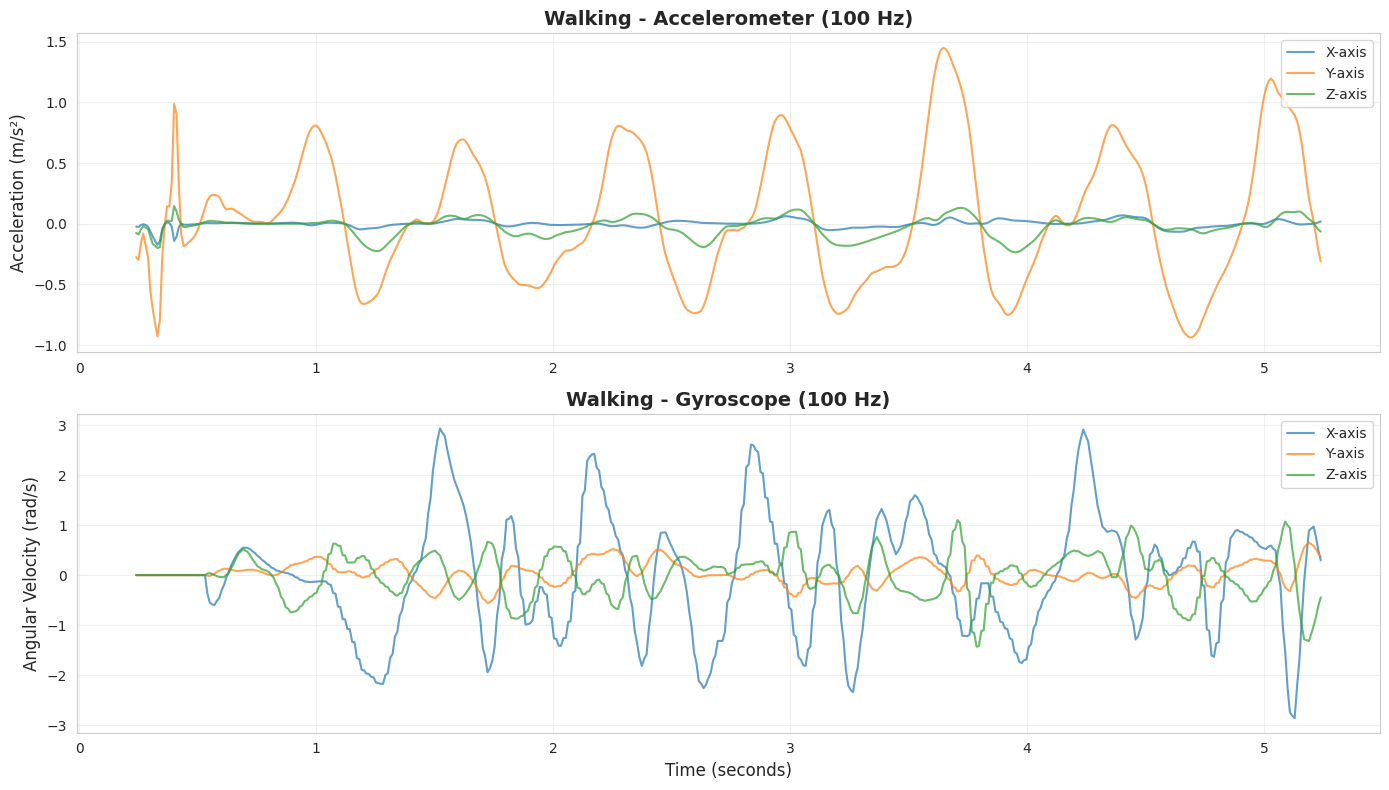

Plotting standing...


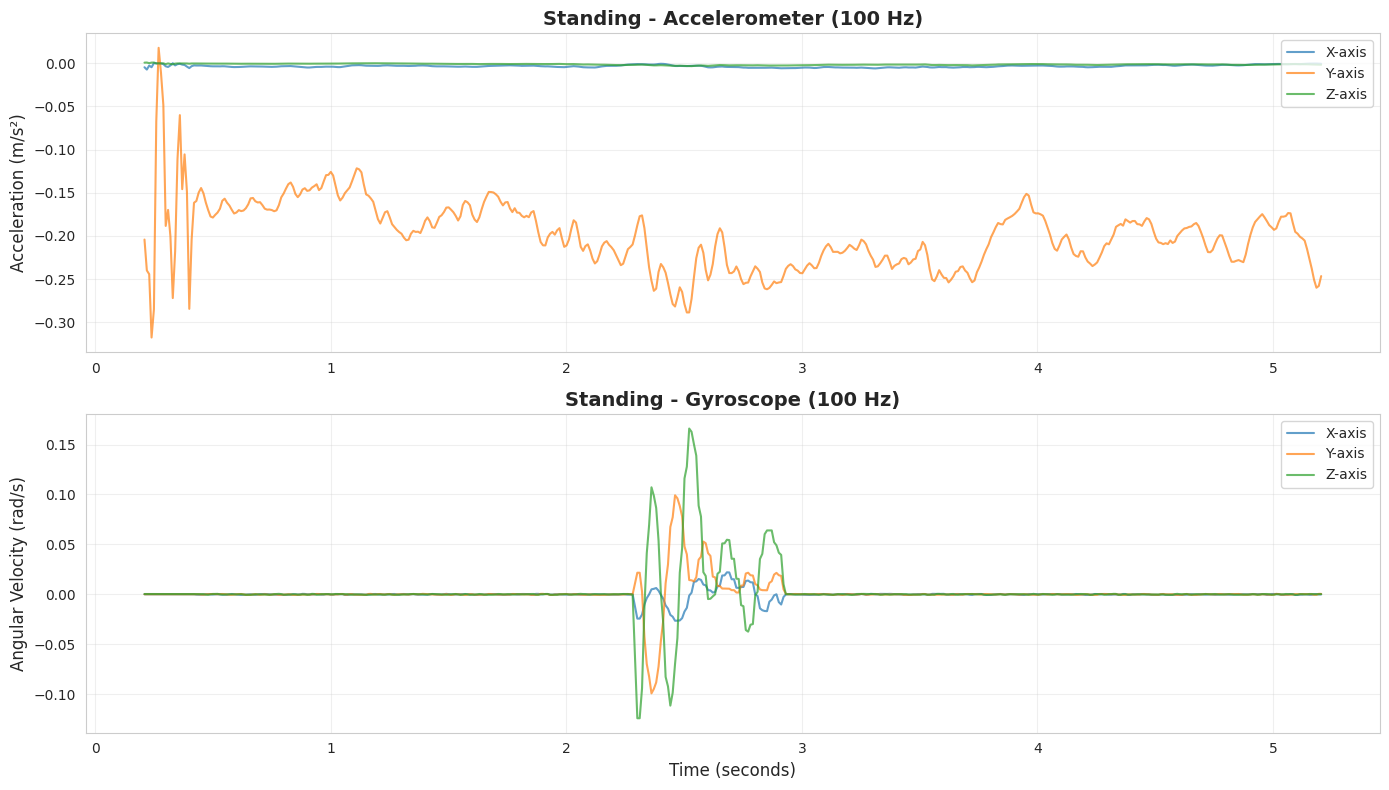

Plotting jumping...


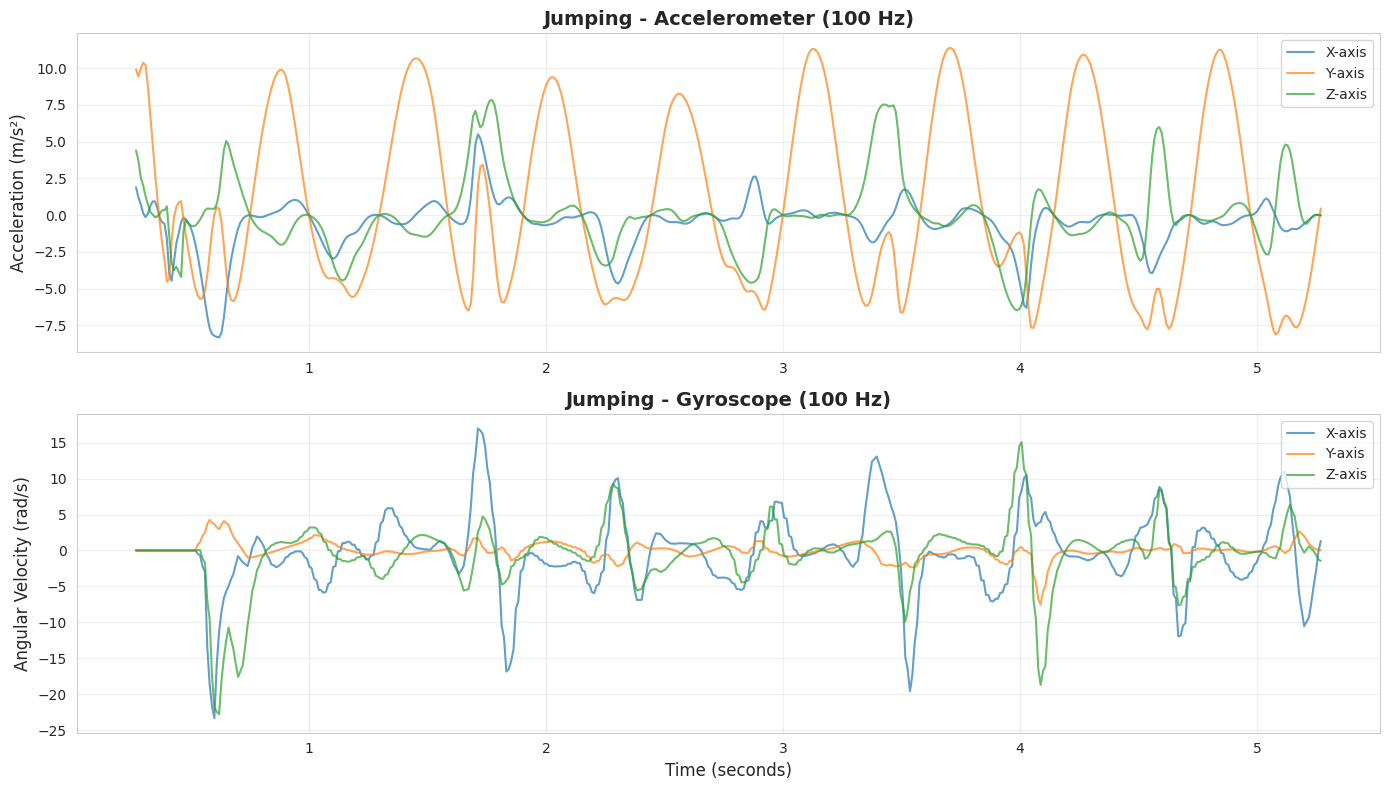

Plotting still...


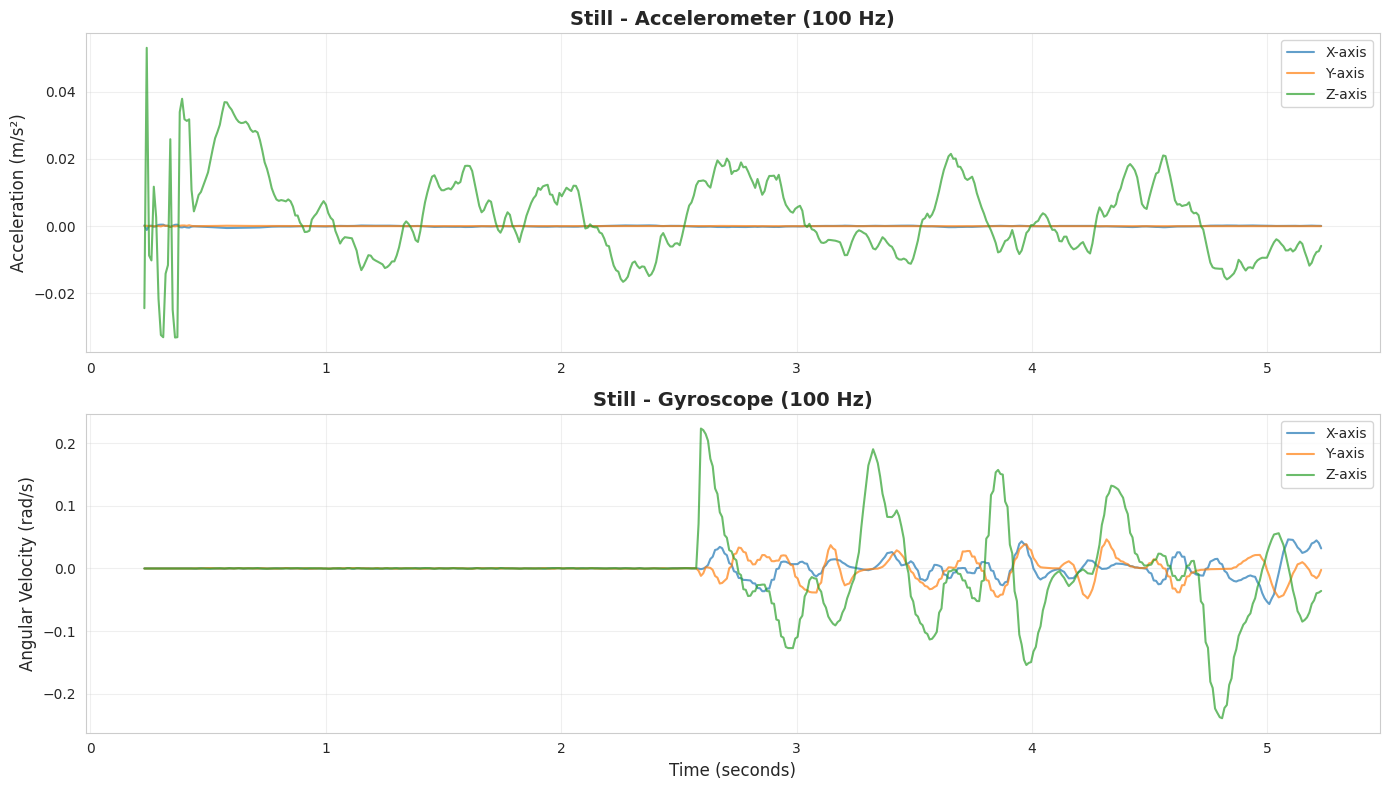


✅ All visualizations saved!


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def plot_activity_comparison(df, activity, max_samples=500):
    """Plot comparison of accelerometer and gyroscope data for an activity"""
    activity_data = df[df['activity'] == activity].head(max_samples)

    fig, axes = plt.subplots(2, 1, figsize=(14, 8))

    # Accelerometer
    axes[0].plot(activity_data['seconds_elapsed'], activity_data['x_acc'],
                 label='X-axis', alpha=0.7, linewidth=1.5)
    axes[0].plot(activity_data['seconds_elapsed'], activity_data['y_acc'],
                 label='Y-axis', alpha=0.7, linewidth=1.5)
    axes[0].plot(activity_data['seconds_elapsed'], activity_data['z_acc'],
                 label='Z-axis', alpha=0.7, linewidth=1.5)
    axes[0].set_title(f'{activity.capitalize()} - Accelerometer (100 Hz)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Acceleration (m/s²)', fontsize=12)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)

    # Gyroscope
    axes[1].plot(activity_data['seconds_elapsed'], activity_data['x_gyro'],
                 label='X-axis', alpha=0.7, linewidth=1.5)
    axes[1].plot(activity_data['seconds_elapsed'], activity_data['y_gyro'],
                 label='Y-axis', alpha=0.7, linewidth=1.5)
    axes[1].plot(activity_data['seconds_elapsed'], activity_data['z_gyro'],
                 label='Z-axis', alpha=0.7, linewidth=1.5)
    axes[1].set_title(f'{activity.capitalize()} - Gyroscope (100 Hz)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time (seconds)', fontsize=12)
    axes[1].set_ylabel('Angular Velocity (rad/s)', fontsize=12)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{activity}_sensor_data.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

# Plot each activity
for activity in ['walking', 'standing', 'jumping', 'still']:
    print(f"Plotting {activity}...")
    plot_activity_comparison(harmonized_dataset, activity)

print("\n✅ All visualizations saved!")

# Feature Extraction

In [44]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.fft import fft

# --- Parameters ---
WINDOW_SIZE = 100   # number of samples per window (1 second at 100Hz)
STEP_SIZE   = 50    # overlap between windows

participants = {
    'Jean-Pierre': '/content/drive/MyDrive/HMM/Jean-pierre_data',
    'Marion': '/content/drive/MyDrive/HMM/Marion_data'
}

activities = ['walking', 'standing', 'jumping', 'still']

all_features = []

# --- Helper function to extract features from a single window ---
def extract_window_features(df_window):
    features = {}

    for axis in ['x_acc', 'y_acc', 'z_acc']:
        data = df_window[axis].values
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std']  = np.std(data)
        features[f'{axis}_var']  = np.var(data)
        features[f'{axis}_max']  = np.max(data)
        features[f'{axis}_min']  = np.min(data)
        features[f'{axis}_energy'] = np.sum(data**2)/len(data)

        # FFT-based features
        fft_vals = np.abs(fft(data))
        features[f'{axis}_dominant_freq'] = np.argmax(fft_vals)
        features[f'{axis}_spectral_energy'] = np.sum(fft_vals**2)

    for axis in ['x_gyro', 'y_gyro', 'z_gyro']:
        data = df_window[axis].values
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std']  = np.std(data)
        features[f'{axis}_var']  = np.var(data)
        features[f'{axis}_max']  = np.max(data)
        features[f'{axis}_min']  = np.min(data)
        features[f'{axis}_energy'] = np.sum(data**2)/len(data)

    # Correlation and signal magnitude area
    acc = df_window[['x_acc','y_acc','z_acc']].values
    gyro = df_window[['x_gyro','y_gyro','z_gyro']].values
    features['acc_sma'] = np.sum(np.abs(acc)) / len(acc)
    features['gyro_sma'] = np.sum(np.abs(gyro)) / len(gyro)

    features['acc_corr_xy'] = np.corrcoef(acc[:,0], acc[:,1])[0,1] if len(acc) > 1 else 0
    features['acc_corr_xz'] = np.corrcoef(acc[:,0], acc[:,2])[0,1] if len(acc) > 1 else 0
    features['acc_corr_yz'] = np.corrcoef(acc[:,1], acc[:,2])[0,1] if len(acc) > 1 else 0

    features['gyro_corr_xy'] = np.corrcoef(gyro[:,0], gyro[:,1])[0,1] if len(gyro) > 1 else 0
    features['gyro_corr_xz'] = np.corrcoef(gyro[:,0], gyro[:,2])[0,1] if len(gyro) > 1 else 0
    features['gyro_corr_yz'] = np.corrcoef(gyro[:,1], gyro[:,2])[0,1] if len(gyro) > 1 else 0

    return features

# --- Loop over participants and activities ---
for participant, base_path in participants.items():
    for activity in activities:
        activity_path = os.path.join(base_path, activity)
        if not os.path.exists(activity_path):
            print(f"⚠️ Activity folder missing: {activity_path}")
            continue

        for rec_folder in sorted(os.listdir(activity_path)):
            rec_path = os.path.join(activity_path, rec_folder)
            if not os.path.isdir(rec_path):
                continue

            # Load merged accelerometer + gyroscope
            try:
                acc_df  = pd.read_csv(os.path.join(rec_path, 'Accelerometer.csv'))
                gyro_df = pd.read_csv(os.path.join(rec_path, 'Gyroscope.csv'))
            except FileNotFoundError:
                print(f"⚠️ Missing sensor files in {rec_path}, skipping.")
                continue

            # Ensure 'seconds_elapsed' exists
            for df in [acc_df, gyro_df]:
                if 'seconds_elapsed' not in df.columns and 'time' in df.columns:
                    df['seconds_elapsed'] = (df['time'] - df['time'].iloc[0]) / 1e9

            # Merge on seconds_elapsed
            df = pd.merge_asof(
                acc_df[['seconds_elapsed','x','y','z']].rename(columns={'x':'x_acc','y':'y_acc','z':'z_acc'}),
                gyro_df[['seconds_elapsed','x','y','z']].rename(columns={'x':'x_gyro','y':'y_gyro','z':'z_gyro'}),
                on='seconds_elapsed', direction='nearest'
            )
            df['participant'] = participant
            df['activity'] = activity
            df['recording_id'] = rec_folder

            # --- Sliding window feature extraction ---
            n_samples = len(df)
            for start in range(0, n_samples - WINDOW_SIZE + 1, STEP_SIZE):
                window = df.iloc[start:start+WINDOW_SIZE]
                features = extract_window_features(window)
                features['participant'] = participant
                features['activity'] = activity
                features['recording_id'] = rec_folder
                all_features.append(features)

# --- Save to CSV ---
features_df = pd.DataFrame(all_features)
features_df.to_csv('Extracted_Features.csv', index=False)
print("✅ Feature extraction complete. Participants included:", features_df['participant'].unique())

✅ Feature extraction complete. Participants included: ['Jean-Pierre' 'Marion']


# Model Training

Participants in dataset: ['Jean-Pierre' 'Marion']
NaNs per column before cleaning:
 x_acc_mean               0
x_acc_std                0
x_acc_var                0
x_acc_max                0
x_acc_min                0
x_acc_energy             0
x_acc_dominant_freq      0
x_acc_spectral_energy    0
y_acc_mean               0
y_acc_std                0
y_acc_var                0
y_acc_max                0
y_acc_min                0
y_acc_energy             0
y_acc_dominant_freq      0
y_acc_spectral_energy    0
z_acc_mean               0
z_acc_std                0
z_acc_var                0
z_acc_max                0
z_acc_min                0
z_acc_energy             0
z_acc_dominant_freq      0
z_acc_spectral_energy    0
x_gyro_mean              0
x_gyro_std               0
x_gyro_var               0
x_gyro_max               0
x_gyro_min               0
x_gyro_energy            0
y_gyro_mean              0
y_gyro_std               0
y_gyro_var               0
y_gyro_max               

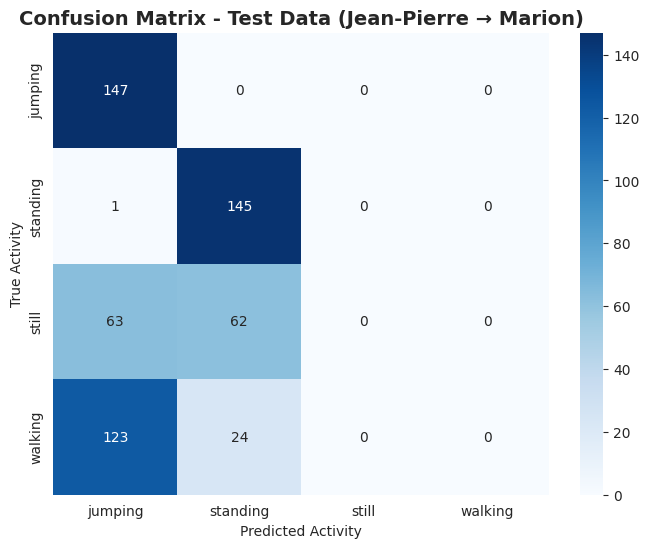

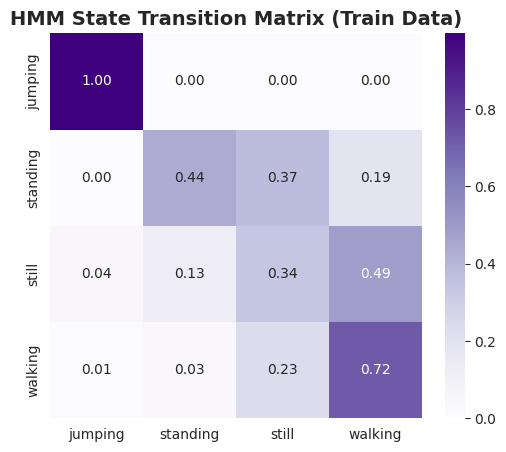

✅ Test predictions saved to 'HMM_TestPredictions.csv'


In [47]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Load features ---
features_df = pd.read_csv('Extracted_Features.csv')

# Strip whitespace just in case
features_df['participant'] = features_df['participant'].str.strip()

# --- Step 2: Ensure both participants are included ---
print("Participants in dataset:", features_df['participant'].unique())

# --- Step 3: Handle NaNs ---
nan_counts = features_df.isna().sum()
print("NaNs per column before cleaning:\n", nan_counts)
features_df = features_df.fillna(0)
print("✅ NaNs handled.")

# --- Step 4: Split train/test by participant ---
train_df = features_df[features_df['participant'] == 'Jean-Pierre'].sort_values(by='recording_id')
test_df  = features_df[features_df['participant'] == 'Marion'].sort_values(by='recording_id')

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

if len(train_df) == 0 or len(test_df) == 0:
    raise ValueError("Train or test set is empty. Check participant names in the CSV.")

# --- Step 5: Prepare features and labels ---
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['activity'])
y_test  = label_encoder.transform(test_df['activity'])  # same encoding

X_train = train_df.drop(columns=['participant', 'activity', 'recording_id']).values
X_test  = test_df.drop(columns=['participant', 'activity', 'recording_id']).values

# --- Step 6: Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- Step 7: Train HMM ---
n_states = len(label_encoder.classes_)
model = hmm.GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=200, random_state=42)
model.fit(X_train_scaled)
print("✅ HMM trained on Jean-Pierre data!")

# --- Step 8: Decode hidden states on test data (Viterbi) ---
hidden_states_test = model.predict(X_test_scaled)

# --- Step 9: Align hidden states to activity labels using training majority vote ---
state_label_map = {}
hidden_states_train = model.predict(X_train_scaled)
for i in range(n_states):
    mask = (hidden_states_train == i)
    if np.sum(mask) == 0:
        continue
    # Use mode to get majority label
    majority_label = train_df.loc[mask, 'activity'].mode()[0]
    state_label_map[i] = majority_label

decoded_test_labels = [state_label_map.get(s, 'unknown') for s in hidden_states_test]
test_df['predicted_activity'] = decoded_test_labels

# --- Step 10: Evaluate accuracy ---
acc = accuracy_score(test_df['activity'], test_df['predicted_activity'])
print(f"✅ Generalization Accuracy (Jean-Pierre → Marion): {acc:.3f}")

# --- Step 11: Confusion matrix ---
cm = confusion_matrix(test_df['activity'], test_df['predicted_activity'], labels=label_encoder.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Test Data (Jean-Pierre → Marion)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.show()

# --- Step 12: Transition matrix visualization (train data) ---
plt.figure(figsize=(6,5))
sns.heatmap(model.transmat_, annot=True, cmap='Purples', fmt='.2f',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("HMM State Transition Matrix (Train Data)", fontsize=14, fontweight='bold')
plt.show()

# --- Step 13: Save test predictions ---
test_df.to_csv("HMM_TestPredictions.csv", index=False)
print("✅ Test predictions saved to 'HMM_TestPredictions.csv'")
